In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates

In [10]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [11]:
os.chdir('/home/MA')

In [12]:
from Battery_dispatch_function import BatteryDispatch

## Define Parameter

Electricity mix carbon intensity for Spain

Ember AG-Energiebilanzen (Daniel's Excel sheet)

In [13]:
grid_emissions_Spain = 228 # g CO2/kWh

In [14]:
battery_sizes = [0, 6, 12, 18, 24, 30]

In [15]:
conv_eff = 0.2 # 2020 slide 7 on https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/Photovoltaics-Report.pdf

Define PV sizing **HERE**

In [16]:
PV_size = 6 #kW_p

According to https://www.energieheld.de/solaranlage/photovoltaik and https://www.energieheld.ch/solaranlagen/photovoltaik#:~:text=Rechnen%20Sie%20im%20Durchschnitt%20etwa,dieser%20Gr%C3%B6sse%20installieren%20zu%20k%C3%B6nnen, 6 m2 are required per kW_p

In [17]:
size = 6*PV_size # m2 necessary for 6 kW_p

In [18]:
HW_boiler_eff = 1
HP_COP = 3.1
AC_EER = 8.5

In [19]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [20]:
eta_discharge = 0.85

In [21]:
PV_lifetime = 25 #years

In [22]:
battery_lifetime = 15 # years

Battery production energy intensity from https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

In [23]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [24]:
CO2_intensity_China = 637

In [25]:
electricity_PV_production = 1597 # kWh_el kWp-1

## Start calculations

Methodology based on this paper: https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

Get local data from https://re.jrc.ec.europa.eu/pvg_tools/en/#HR
for years 2010-2016 to average yearly variability
Solar panels were assumed to be 46 inclined towards south to maximize yearly yield without the need for sophisticated mechanic installations.

Read data into dataframe

For Switzerland, a weather station near Zurich airport was chosen (LSZH)

In [26]:
HDD_CH = pd.read_csv('Data/LSZH_HDD_12C.csv')

For Spain, LEZL station near Sevilla was selected

In [27]:
HDD_Spain = pd.read_csv('Data/LEZL_HDD_12C.csv')

In [28]:
load_CH = pd.read_pickle('Calculations/CH/load_CH_separated.pkl')

Goal: to recreate a heating demand profile for Spain based on the one provided for Switzerland.
Approach: Divide all heating energy by total of heating degree days for Switzerland, then multiply Spain's heating degree days. Same approach for cooling demand.


Calculations were carried out with base temperature of 12° Celsius for heating and 25° Celsius for cooling, which is a valid assumption based on https://www.sciencedirect.com/science/article/pii/S2352710218301086#:~:text=The%20air%20temperature%20is%20defined,the%20basis%20for%20climate%20classification.
Source for heating and cooling days : https://www.degreedays.net/#

## First, let's deal with heating:

In [29]:
Total_elec_heating_CH = sum(load_CH['Electricity for Space Heating [kWh]'])

In [30]:
Total_elec_heating_CH

1034.6743396814395

In [31]:
HDD_Spain['Date'] = pd.to_datetime(HDD_Spain['Date'], format='%d-%m-%y')

In [32]:
HDD_Spain = HDD_Spain[~((HDD_Spain.Date.dt.month == 2) & (HDD_Spain.Date.dt.day == 29))]

In [33]:
HDD_Spain_averaged = HDD_Spain.groupby([HDD_Spain["Date"].dt.month, HDD_Spain["Date"].dt.day, HDD_Spain["Date"].dt.hour]).mean()

In [34]:
HDD_Spain_averaged.index.names = ["month", "day", "hour"]

In [35]:
HDD_CH['Date'] = pd.to_datetime(HDD_CH['Date'], format='%d-%m-%y')

In [36]:
HDD_CH = HDD_CH[~((HDD_CH.Date.dt.month == 2) & (HDD_CH.Date.dt.day == 29))]

In [37]:
HDD_CH_averaged = HDD_CH.groupby([HDD_CH["Date"].dt.month, HDD_CH["Date"].dt.day, HDD_CH["Date"].dt.hour]).mean()

In [38]:
HDD_CH_averaged.index.names = ["month", "day", "hour"]

In [39]:
Total_HDD_CH = sum(HDD_CH_averaged['HDD 12'])
Total_HDD_CH

1523.0083333333332

In [40]:
Total_HDD_Spain = sum(HDD_Spain_averaged['HDD 12'])
Total_HDD_Spain

185.13333333333316

Reproduce a hourly profile for new locations based on climate pattern averaging Switzerland's daily profile

In [41]:
load_CH.index.get_level_values('hour')

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='hour', length=8760)

In [42]:
heating_hourly_averaged_CH = load_CH['Electricity for Space Heating [kWh]'].groupby(load_CH.index.get_level_values('hour')).mean()

In [43]:
heating_hourly_normalized_CH = heating_hourly_averaged_CH/sum(heating_hourly_averaged_CH)

In [44]:
load_Spain = load_CH.copy()

In [45]:
ratio_CH = Total_elec_heating_CH/Total_HDD_CH
ratio_CH # kWh/HDD

0.679362231339141

In [46]:
HDD_Spain_averaged['HDD 12'].repeat(24)

month  day  hour
1      1    0       2.966667
            0       2.966667
            0       2.966667
            0       2.966667
            0       2.966667
                      ...   
12     31   0       3.133333
            0       3.133333
            0       3.133333
            0       3.133333
            0       3.133333
Name: HDD 12, Length: 8760, dtype: float64

In [47]:
heating_hourly_normalized_CH_df = np.tile(heating_hourly_normalized_CH, 365)
len(heating_hourly_normalized_CH_df)

8760

In [48]:
load_Spain['Electricity for Space Heating [kWh]'] = HDD_Spain_averaged['HDD 12'].repeat(24).values * heating_hourly_normalized_CH_df * ratio_CH

In [49]:
sum(load_Spain['Electricity for Space Heating [kWh]'])

125.77259442858605

In [50]:
crosscheck = Total_elec_heating_CH*Total_HDD_Spain/Total_HDD_CH
crosscheck

125.77259442858617

## Now, let's analyze cooling demand

In [51]:
CDD_CH = pd.read_csv('Data/LSZH_CDD_22C+-3C.csv')

For Spain, LEZL station near Sevilla was selected

In [52]:
CDD_Spain = pd.read_csv('Data/LEZL_CDD_22C+-3C.csv')

Reproduce a hourly profile for new locations based on climate pattern averaging Switzerland's daily profile

In [53]:
Total_elec_cooling_CH = sum(load_CH['Electricity for Space Cooling [kWh]'])

In [54]:
Total_elec_cooling_CH

1144.119406827451

In [55]:
CDD_Spain['Date'] = pd.to_datetime(CDD_Spain['Date'], format='%d-%m-%y')

In [56]:
CDD_Spain = CDD_Spain[~((CDD_Spain.Date.dt.month == 2) & (CDD_Spain.Date.dt.day == 29))]

In [57]:
CDD_Spain_averaged = CDD_Spain.groupby([CDD_Spain["Date"].dt.month, CDD_Spain["Date"].dt.day, CDD_Spain["Date"].dt.hour]).mean()

In [58]:
CDD_Spain_averaged.index.names = ["month", "day", "hour"]

In [59]:
CDD_CH['Date'] = pd.to_datetime(CDD_CH['Date'], format='%d-%m-%y')

In [60]:
CDD_CH = CDD_CH[~((CDD_CH.Date.dt.month == 2) & (CDD_CH.Date.dt.day == 29))]

In [61]:
CDD_CH_averaged = CDD_CH.groupby([CDD_CH["Date"].dt.month, CDD_CH["Date"].dt.day, CDD_CH["Date"].dt.hour]).mean()

In [62]:
CDD_CH_averaged.index.names = ["month", "day", "hour"]

In [63]:
Total_CDD_CH = sum(CDD_CH_averaged['CDD 25'])
Total_CDD_CH

55.50833333333335

In [64]:
Total_CDD_Spain = sum(CDD_Spain_averaged['CDD 25'])
Total_CDD_Spain

428.1416666666667

In [65]:
cooling_hourly_averaged_CH = load_CH['Electricity for Space Cooling [kWh]'].groupby(load_CH.index.get_level_values('hour')).mean()

In [66]:
cooling_hourly_normalized_CH = cooling_hourly_averaged_CH/sum(cooling_hourly_averaged_CH)

In [67]:
ratio_CH = Total_elec_cooling_CH/Total_CDD_CH
ratio_CH # kWh/HDD

20.6116692417496

In [68]:
cooling_hourly_normalized_CH_df = np.tile(cooling_hourly_normalized_CH, 365)
len(cooling_hourly_normalized_CH_df)

8760

In [69]:
load_Spain['Electricity for Space Cooling [kWh]'] = CDD_Spain_averaged['CDD 25'].repeat(24).values * cooling_hourly_normalized_CH_df * ratio_CH

In [70]:
sum(load_Spain['Electricity for Space Cooling [kWh]'])

8824.714421944747

In [71]:
crosscheck = Total_elec_cooling_CH*Total_CDD_Spain/Total_CDD_CH
crosscheck

8824.714421944744

In [72]:
load_Spain['Total Electricity'] = load_Spain['Electricity demand [kWh](Hourly) '] + load_Spain['Electricity for Space Heating [kWh]'] + load_Spain['Electricity for Hot Water [kWh]'] + load_Spain['Electricity for Space Cooling [kWh]']

In [73]:
total_elec_load = load_Spain['Total Electricity']

## Start processing of solar production data

In [74]:
meteo_data = pd.read_csv('Data/PV_Sevilla.csv')

Convert time column to datetime format to facilitate data processing

In [75]:
meteo_data['time'] = pd.to_datetime(meteo_data['time'], format='%Y%m%d:%H%M')

Get rid of leap years

In [76]:
meteo_data = meteo_data[~((meteo_data.time.dt.month == 2) & (meteo_data.time.dt.day == 29))]

Check length of dataset to be 7 years x 365 days/year x 24 hours/day = 61320 days

In [77]:
len(meteo_data)

61320

Check date of maximum value

In [78]:
meteo_data[meteo_data['G(i)'] == meteo_data['G(i)'].max()]

,time,G(i),H_sun,T2m,WS10m,Int
52716,2016-01-06 12:09:00,1528.42,29.93,15.29,3.28,1


This is the absolute amount of radiation incident on a solar cell in Zurich without accounting for the conversion efficiency. 
As expected, it occurs on the 22th of March, the date where the sun's angle is exactly perpendicular to the panel's orientation.

In [79]:
years = meteo_data.time.dt.year.unique()

In [80]:
results_all = pd.DataFrame()
results_optimization_all = pd.DataFrame()
for year in years:
    meteo_data_year = meteo_data[meteo_data.time.dt.year == year]
    hourly_average=meteo_data_year.groupby([meteo_data_year["time"].dt.month, meteo_data_year["time"].dt.day, meteo_data_year["time"].dt.hour]).mean()
    hourly_average.index.names = ["month", "day", "hour"]
    hourly_average['Prod/m2'] = hourly_average['G(i)']*0.17/1000
    hourly_average['Prod'] = hourly_average['Prod/m2']*size
    yearly_PV_prod = hourly_average['Prod'].sum()
    PV_production = hourly_average['Prod']
    power_balance = pd.DataFrame()
    power_balance['consumption'] = total_elec_load
    power_balance['from PV'] = PV_production
    power_balance['exchange grid'] = PV_production - total_elec_load
    power_balance['to Grid'] = (PV_production - total_elec_load).clip(lower=0)
    power_balance['from Grid'] = (total_elec_load - PV_production).clip(lower=0)
    power_balance = power_balance.fillna(0)
    self_consumption_kWh = sum(power_balance['consumption'] - power_balance['from Grid'])
    total_CO2_PV_prod = electricity_PV_production * PV_size * CO2_intensity_China
    reduced_CO2_PV_g = grid_emissions_Spain * self_consumption_kWh * PV_lifetime - total_CO2_PV_prod
    reduced_CO2_PV_t = reduced_CO2_PV_g/1000000
    results = pd.DataFrame()
    results['battery_size'] = battery_sizes
    results['curtailment'] = ''
    results['yearly_savings_kWh'] = ''
    for i in range(0, len(results['battery_size'])):
        powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
        results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
        results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])
    results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime
    results['yearly_savings_CO2'] = results['yearly_savings_kWh'] * grid_emissions_Spain / 1000000
    results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime
    results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)
    results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000
    results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 
    results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']
    results.set_index("battery_size",drop=True,inplace=True)
    results['net_CO2_savings_with_PV'] = results['net_CO2_savings'] + reduced_CO2_PV_t
    PV_production_hourly = PV_production
    yearly_PV_production = sum(PV_production_hourly) 
    results['total_elec_PV_prod'] = electricity_PV_production * PV_size
    results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))
    results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']
    results['EROI_grid_useful'] = results['EROI_gen']
    results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])
    results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))
    results['ESOI'] = results['ESOI'].fillna(0)
    curtailment_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    #curtailment_thresholds = [0.4, 0.5]
    battery_size = list(range(0, 25))
    pd.options.mode.chained_assignment = None  # default='warn'
    
    results_optimization = pd.DataFrame()
    results_optimization['curtailment'] = curtailment_thresholds
    results_optimization['optimal_battery_size'] = ''    
    results_optimization['net_CO2_savings'] = ''
        
    for curtailment in curtailment_thresholds:   
        
        temp = 0
        max_power_allowed = curtailment*PV_size
        PV_production_used = PV_production.copy()
        PV_production_used[PV_production_used > max_power_allowed] = max_power_allowed
        PV_production_curtailed = PV_production - max_power_allowed
        PV_production_curtailed[PV_production_curtailed < 0] = 0
        power_balance = pd.DataFrame()
        power_balance['consumption'] = total_elec_load
        power_balance['from PV'] = PV_production_curtailed
        power_balance['exchange grid'] = PV_production_curtailed - total_elec_load
        power_balance['to Grid'] = (PV_production_curtailed - total_elec_load).clip(lower=0)
        power_balance['from Grid'] = (total_elec_load - PV_production_curtailed).clip(lower=0)
        power_balance = power_balance.fillna(0)
        
        temp = pd.DataFrame()
        temp['battery_size'] = battery_size
        temp['yearly_savings_kWh'] = ''
        temp['yearly_savings_CO2'] = ''
        temp['total_CO2_grid_reduced'] = ''
        temp['total_CO2_battery_prod'] = ''
        temp['net_CO2_savings'] = ''
        for i in range(0, len(temp['battery_size'])):
            powerbalance = BatteryDispatch(power_balance, temp['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
            temp['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
            temp['yearly_savings_CO2'].values[i] = temp['yearly_savings_kWh'].values[i] * grid_emissions_Spain / 1000000
            temp['total_CO2_grid_reduced'].values[i] = temp['yearly_savings_CO2'].values[i] * PV_lifetime
            temp['total_elec_battery_prod'] = 2 * (elec_battery_prod * temp['battery_size']/0.8)
            temp['total_CO2_battery_prod'].values[i] = temp['total_elec_battery_prod'].values[i] * CO2_intensity_China / 1000000
            temp['net_CO2_savings'].values[i] =  temp['total_CO2_grid_reduced'].values[i] - temp['total_CO2_battery_prod'].values[i]
        temp_max = temp[temp['net_CO2_savings']==temp['net_CO2_savings'].max()]
        results_optimization.optimal_battery_size[results_optimization.curtailment == curtailment] = temp_max['battery_size'].values
        results_optimization.net_CO2_savings[results_optimization.curtailment == curtailment] = temp_max['net_CO2_savings'].values
    results_optimization.set_index("curtailment",drop=True,inplace=True)
    results_all = results_all.append(results)
    results_optimization_all = results_optimization_all.append(results_optimization)

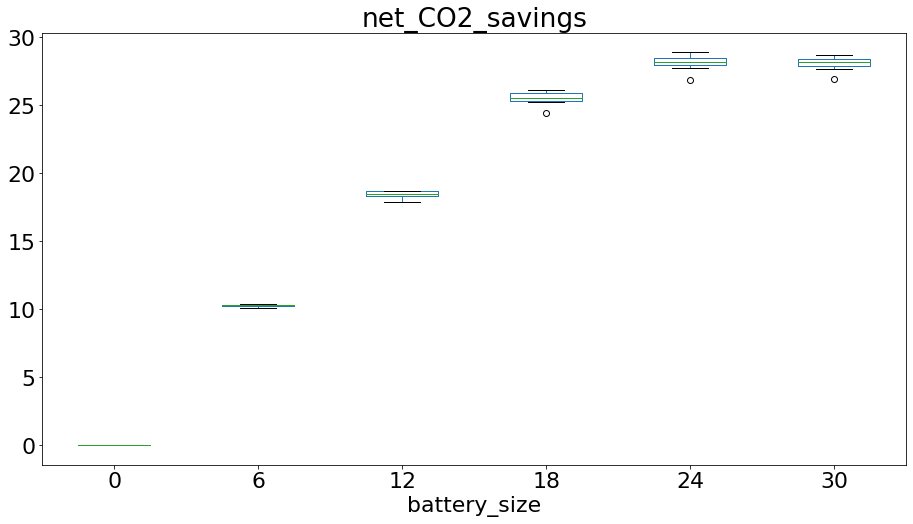

In [81]:
results_all.boxplot(by ='battery_size', column =['net_CO2_savings'], grid = False)
plt.suptitle('');

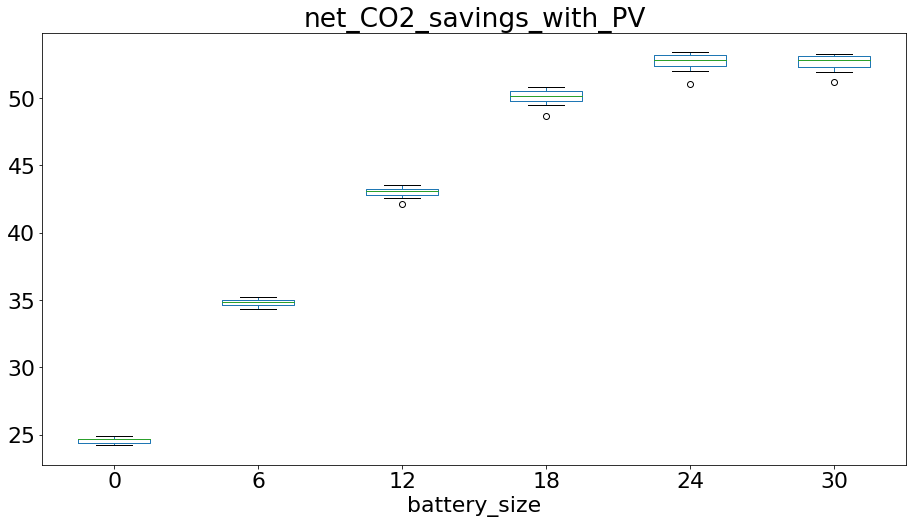

In [82]:
results_all.boxplot(by ='battery_size', column =['net_CO2_savings_with_PV'], grid = False)
plt.suptitle('');

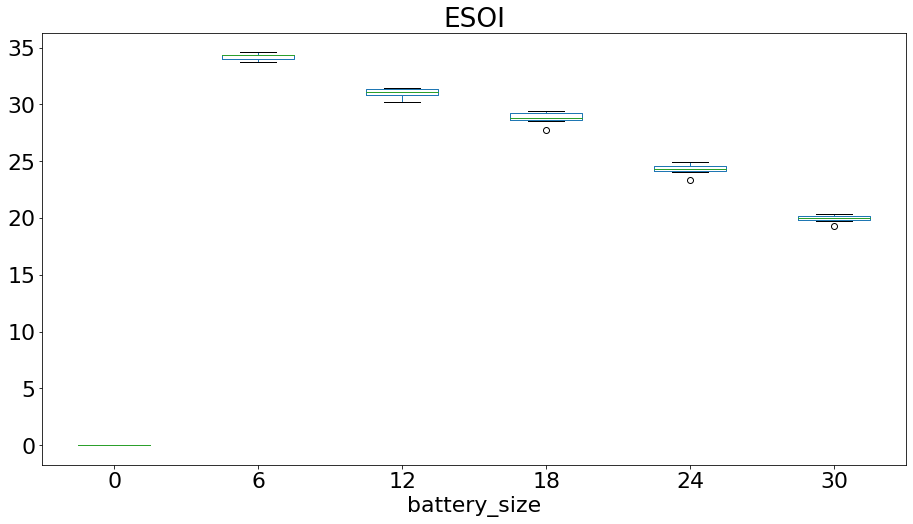

In [83]:
results_all.boxplot(by ='battery_size', column =['ESOI'], grid = False)
plt.suptitle('');

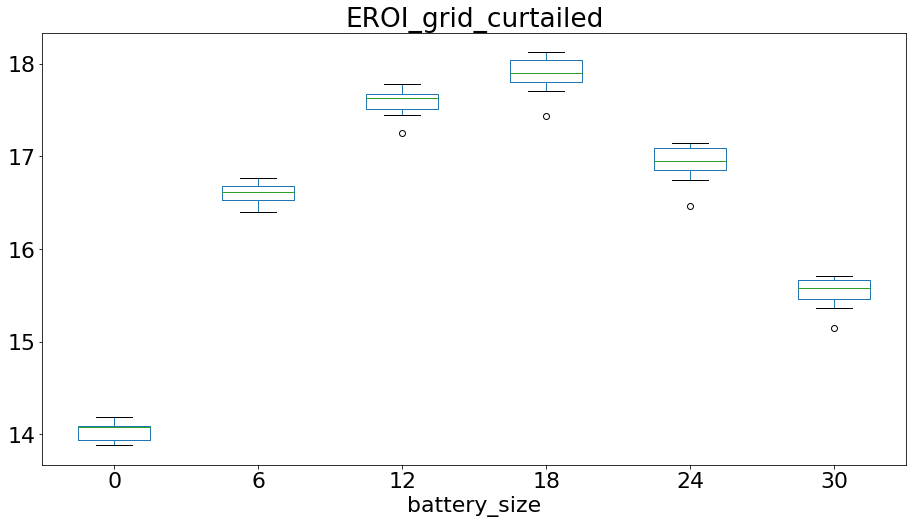

In [84]:
results_all.boxplot(by ='battery_size', column =['EROI_grid_curtailed'], grid = False)
plt.suptitle('');

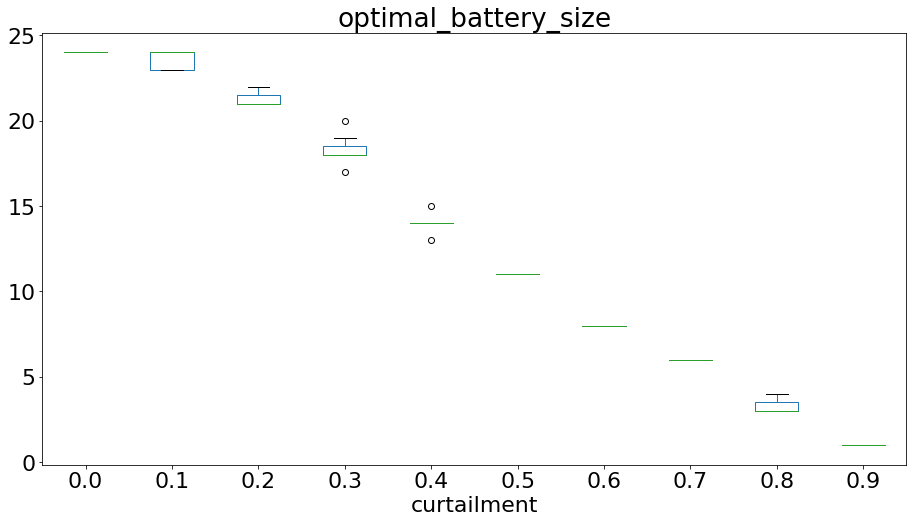

In [85]:
results_optimization_all.boxplot(by ='curtailment', column =['optimal_battery_size'], grid = False)
plt.suptitle('');

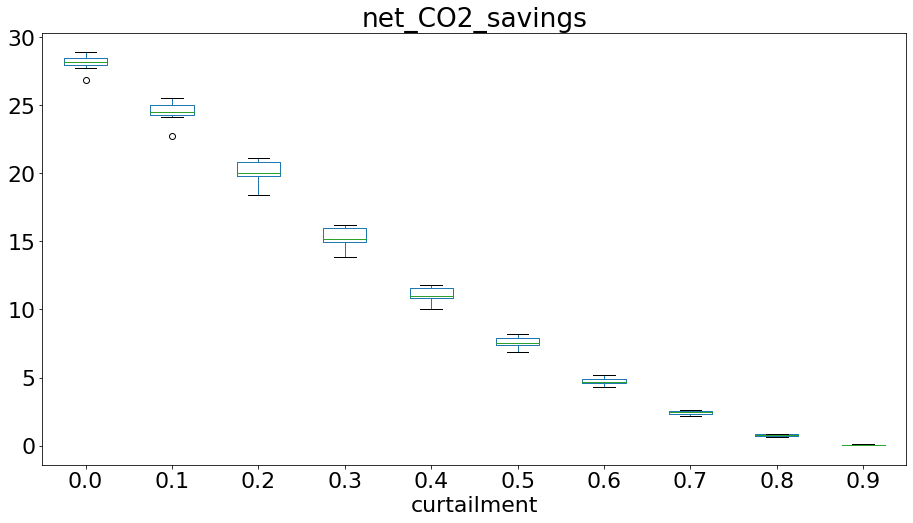

In [86]:
results_optimization_all.boxplot(by ='curtailment', column =['net_CO2_savings'], grid = False)
plt.suptitle('');

## Explore results using momentary CO2-emissions (electricitymap)

In [152]:
emissions_spain = pd.read_csv('Data/ES 2020.csv')

In [153]:
emissions_spain.head()

,datetime,created_at,updated_at,timestamp,zone_name,carbon_intensity_avg,carbon_intensity_production_avg,carbon_intensity_discharge_avg,carbon_intensity_import_avg,carbon_rate_avg,...,latest_forecasted_precipitation_avg,latest_forecasted_price_avg,latest_forecasted_production_avg,latest_forecasted_consumption_avg,latest_forecasted_power_net_import_ES-IB-MA_avg,latest_forecasted_power_net_import_FR_avg,latest_forecasted_power_net_import_MA_avg,latest_forecasted_power_net_import_PT_avg,latest_forecasted_production_solar_avg,latest_forecasted_production_wind_avg
0,2020-01-01T00:00:00+00:00,2021-06-17T10:03:46.273583+00:00,2021-06-17T10:03:46.273583+00:00,1577836800,ES,192.72,187.39,NaN,539.27,NaN,...,0.0,38.60,20383.0,22592.0,NaN,-358.0,NaN,-277.0,13.0,1543.0
1,2020-01-01T01:00:00+00:00,2021-06-17T10:03:46.273583+00:00,2021-06-17T10:03:46.273583+00:00,1577840400,ES,189.05,183.52,NaN,539.27,NaN,...,0.0,36.55,20218.0,21332.0,NaN,-301.0,NaN,-813.0,11.0,1595.0
2,2020-01-01T02:00:00+00:00,2021-06-17T10:03:46.273583+00:00,2021-06-17T10:03:46.273583+00:00,1577844000,ES,184.93,180.64,NaN,539.27,NaN,...,0.0,32.32,20510.0,20103.0,NaN,-614.0,NaN,-786.0,9.0,1621.0
3,2020-01-01T03:00:00+00:00,2021-06-17T10:03:46.273583+00:00,2021-06-17T10:03:46.273583+00:00,1577847600,ES,186.94,183.34,NaN,539.27,NaN,...,0.0,30.85,20809.0,19371.0,NaN,-1108.0,NaN,-308.0,11.0,1632.0
4,2020-01-01T04:00:00+00:00,2021-06-17T10:03:46.273583+00:00,2021-06-17T10:03:46.273583+00:00,1577851200,ES,188.19,183.92,NaN,539.27,NaN,...,0.0,30.14,20710.0,19215.0,NaN,-1121.0,NaN,-269.0,11.0,1666.0


In [154]:
emissions_spain.datetime = pd.to_datetime(emissions_spain.datetime, format='%Y-%m-%dT%H')

In [155]:
emissions_spain = emissions_spain[~((emissions_spain.datetime.dt.month == 2) & (emissions_spain.datetime.dt.day == 29))]

In [156]:
emissions_spain = emissions_spain.groupby([emissions_spain['datetime'].dt.month, emissions_spain['datetime'].dt.day, emissions_spain['datetime'].dt.hour]).mean()

In [157]:
emissions_spain.index.names = ["month", "day", "hour"]

In [158]:
emissions_spain['carbon_intensity_avg']

month  day  hour
1      1    0       192.72
            1       189.05
            2       184.93
            3       186.94
            4       188.19
                     ...  
12     31   19      117.42
            20      116.28
            21      116.55
            22      116.79
            23      123.93
Name: carbon_intensity_avg, Length: 8760, dtype: float64

In [166]:
results_all = pd.DataFrame()
results_optimization_all = pd.DataFrame()
for year in years:
    meteo_data_year = meteo_data[meteo_data.time.dt.year == year]
    hourly_average=meteo_data_year.groupby([meteo_data_year["time"].dt.month, meteo_data_year["time"].dt.day, meteo_data_year["time"].dt.hour]).mean()
    hourly_average.index.names = ["month", "day", "hour"]
    hourly_average['Prod/m2'] = hourly_average['G(i)']*0.17/1000
    hourly_average['Prod'] = hourly_average['Prod/m2']*size
    yearly_PV_prod = hourly_average['Prod'].sum()
    PV_production = hourly_average['Prod']
    power_balance = pd.DataFrame()
    power_balance['consumption'] = total_elec_load
    power_balance['from PV'] = PV_production
    power_balance['exchange grid'] = PV_production - total_elec_load
    power_balance['to Grid'] = (PV_production - total_elec_load).clip(lower=0)
    power_balance['from Grid'] = (total_elec_load - PV_production).clip(lower=0)
    power_balance = power_balance.fillna(0)
    power_balance['self_consumption_kWh'] = (power_balance['consumption'] - power_balance['from Grid'])
    total_CO2_PV_prod = electricity_PV_production * PV_size * CO2_intensity_China
    power_balance['reduced_CO2_PV_g'] = emissions_spain['carbon_intensity_avg'] * power_balance['self_consumption_kWh']
    reduced_CO2_PV_g = sum(power_balance['reduced_CO2_PV_g']) * PV_lifetime - total_CO2_PV_prod
    reduced_CO2_PV_t = reduced_CO2_PV_g/1000000
    results = pd.DataFrame()
    results['battery_size'] = battery_sizes
    results['curtailment'] = ''
    results['yearly_savings_kWh'] = ''
    for i in range(0, len(results['battery_size'])):
        powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
        power_balance['reduced_CO2_PV_g'] = emissions_spain['carbon_intensity_avg'] * power_balance['Discharging']
        results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
        results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])
    results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime
    results['yearly_savings_CO2'] = sum(power_balance['reduced_CO2_PV_g']) / 1000000
    results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime
    results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)
    results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000
    results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 
    results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']
    results.set_index("battery_size",drop=True,inplace=True)
    results['net_CO2_savings_with_PV'] = results['net_CO2_savings'] + reduced_CO2_PV_t
    PV_production_hourly = PV_production
    yearly_PV_production = sum(PV_production_hourly) 
    results['total_elec_PV_prod'] = electricity_PV_production * PV_size
    results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))
    results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']
    results['EROI_grid_useful'] = results['EROI_gen']
    results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])
    results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))
    results['ESOI'] = results['ESOI'].fillna(0)
    curtailment_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    #curtailment_thresholds = [0.4, 0.5]
    battery_size = list(range(0, 25))
    pd.options.mode.chained_assignment = None  # default='warn'
    
    results_optimization = pd.DataFrame()
    results_optimization['curtailment'] = curtailment_thresholds
    results_optimization['optimal_battery_size'] = ''    
    results_optimization['net_CO2_savings'] = ''
        
    for curtailment in curtailment_thresholds:   
        
        temp = 0
        max_power_allowed = curtailment*PV_size
        PV_production_used = PV_production.copy()
        PV_production_used[PV_production_used > max_power_allowed] = max_power_allowed
        PV_production_curtailed = PV_production - max_power_allowed
        PV_production_curtailed[PV_production_curtailed < 0] = 0
        power_balance = pd.DataFrame()
        power_balance['consumption'] = total_elec_load
        power_balance['from PV'] = PV_production_curtailed
        power_balance['exchange grid'] = PV_production_curtailed - total_elec_load
        power_balance['to Grid'] = (PV_production_curtailed - total_elec_load).clip(lower=0)
        power_balance['from Grid'] = (total_elec_load - PV_production_curtailed).clip(lower=0)
        power_balance = power_balance.fillna(0)
        
        temp = pd.DataFrame()
        temp['battery_size'] = battery_size
        temp['reduced_CO2_PV_g'] = ''
        temp['yearly_savings_kWh'] = ''
        temp['yearly_savings_CO2'] = ''
        temp['total_CO2_grid_reduced'] = ''
        temp['total_CO2_battery_prod'] = ''
        temp['net_CO2_savings'] = ''
        for i in range(0, len(temp['battery_size'])):
            powerbalance = BatteryDispatch(power_balance, temp['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
            #temp['reduced_CO2_PV_g'].values[i] = sum(emissions_spain['carbon_intensity_avg'] * power_balance['Discharging'])
            temp['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
            temp['yearly_savings_CO2'].values[i] = sum(emissions_spain['carbon_intensity_avg'] * power_balance['Discharging']) / 1000000
            temp['total_CO2_grid_reduced'].values[i] = temp['yearly_savings_CO2'].values[i] * PV_lifetime
            temp['total_elec_battery_prod'] = 2 * (elec_battery_prod * temp['battery_size']/0.8)
            temp['total_CO2_battery_prod'].values[i] = temp['total_elec_battery_prod'].values[i] * CO2_intensity_China / 1000000
            temp['net_CO2_savings'].values[i] =  temp['total_CO2_grid_reduced'].values[i] - temp['total_CO2_battery_prod'].values[i]
        temp_max = temp[temp['net_CO2_savings']==temp['net_CO2_savings'].max()]
        results_optimization.optimal_battery_size[results_optimization.curtailment == curtailment] = temp_max['battery_size'].values
        results_optimization.net_CO2_savings[results_optimization.curtailment == curtailment] = temp_max['net_CO2_savings'].values
    results_optimization.set_index("curtailment",drop=True,inplace=True)
    results_all = results_all.append(results)
    results_optimization_all = results_optimization_all.append(results_optimization)

ValueError: Length of replacements must equal series length

In [167]:
results_all = pd.DataFrame()
results_optimization_all = pd.DataFrame()
for year in years:
    meteo_data_year = meteo_data[meteo_data.time.dt.year == year]
    hourly_average=meteo_data_year.groupby([meteo_data_year["time"].dt.month, meteo_data_year["time"].dt.day, meteo_data_year["time"].dt.hour]).mean()
    hourly_average.index.names = ["month", "day", "hour"]
    hourly_average['Prod/m2'] = hourly_average['G(i)']*0.17/1000
    hourly_average['Prod'] = hourly_average['Prod/m2']*size
    yearly_PV_prod = hourly_average['Prod'].sum()
    PV_production = hourly_average['Prod']
    power_balance = pd.DataFrame()
    power_balance['consumption'] = total_elec_load
    power_balance['from PV'] = PV_production
    power_balance['exchange grid'] = PV_production - total_elec_load
    power_balance['to Grid'] = (PV_production - total_elec_load).clip(lower=0)
    power_balance['from Grid'] = (total_elec_load - PV_production).clip(lower=0)
    power_balance = power_balance.fillna(0)
    power_balance['self_consumption_kWh'] = (power_balance['consumption'] - power_balance['from Grid'])
    total_CO2_PV_prod = electricity_PV_production * PV_size * CO2_intensity_China
    power_balance['reduced_CO2_PV_g'] = emissions_spain['carbon_intensity_avg'] * power_balance['self_consumption_kWh']
    reduced_CO2_PV_g = sum(power_balance['reduced_CO2_PV_g']) * PV_lifetime - total_CO2_PV_prod
    reduced_CO2_PV_t = reduced_CO2_PV_g/1000000
    results = pd.DataFrame()
    results['battery_size'] = battery_sizes
    results['curtailment'] = ''
    results['yearly_savings_kWh'] = ''
    for i in range(0, len(results['battery_size'])):
        powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
        power_balance['reduced_CO2_PV_g'] = emissions_spain['carbon_intensity_avg'] * power_balance['Discharging']
        results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
        results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])
    results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime
    results['yearly_savings_CO2'] = sum(power_balance['reduced_CO2_PV_g']) / 1000000
    results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime
    results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)
    results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000
    results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 
    results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']
    results.set_index("battery_size",drop=True,inplace=True)
    results['net_CO2_savings_with_PV'] = results['net_CO2_savings'] + reduced_CO2_PV_t
    PV_production_hourly = PV_production
    yearly_PV_production = sum(PV_production_hourly) 
    results['total_elec_PV_prod'] = electricity_PV_production * PV_size
    results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))
    results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']
    results['EROI_grid_useful'] = results['EROI_gen']
    results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])
    results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))
    results['ESOI'] = results['ESOI'].fillna(0)
    curtailment_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    #curtailment_thresholds = [0.4, 0.5]
    battery_size = list(range(0, 25))
    pd.options.mode.chained_assignment = None  # default='warn'
    
    results_optimization = pd.DataFrame()
    results_optimization['curtailment'] = curtailment_thresholds
    results_optimization['optimal_battery_size'] = ''    
    results_optimization['net_CO2_savings'] = ''
        
    for curtailment in curtailment_thresholds:   
        
        temp = 0
        max_power_allowed = curtailment*PV_size
        PV_production_used = PV_production.copy()
        PV_production_used[PV_production_used > max_power_allowed] = max_power_allowed
        PV_production_curtailed = PV_production - max_power_allowed
        PV_production_curtailed[PV_production_curtailed < 0] = 0
        power_balance = pd.DataFrame()
        power_balance['consumption'] = total_elec_load
        power_balance['from PV'] = PV_production_curtailed
        power_balance['exchange grid'] = PV_production_curtailed - total_elec_load
        power_balance['to Grid'] = (PV_production_curtailed - total_elec_load).clip(lower=0)
        power_balance['from Grid'] = (total_elec_load - PV_production_curtailed).clip(lower=0)
        power_balance = power_balance.fillna(0)
        
        temp = pd.DataFrame()
        temp['battery_size'] = battery_size
        temp['reduced_CO2_PV_g'] = ''
        temp['yearly_savings_kWh'] = ''
        temp['yearly_savings_CO2'] = ''
        temp['total_CO2_grid_reduced'] = ''
        temp['total_CO2_battery_prod'] = ''
        temp['net_CO2_savings'] = ''
        for i in range(0, len(temp['battery_size'])):
            powerbalance = BatteryDispatch(power_balance, temp['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
            temp['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
            temp['yearly_savings_CO2'].values[i] = temp['yearly_savings_kWh'].values[i] * grid_emissions_Spain / 1000000
            temp['total_CO2_grid_reduced'].values[i] = temp['yearly_savings_CO2'].values[i] * PV_lifetime
            temp['total_elec_battery_prod'] = 2 * (elec_battery_prod * temp['battery_size']/0.8)
            temp['total_CO2_battery_prod'].values[i] = temp['total_elec_battery_prod'].values[i] * CO2_intensity_China / 1000000
            temp['net_CO2_savings'].values[i] =  temp['total_CO2_grid_reduced'].values[i] - temp['total_CO2_battery_prod'].values[i]
        temp_max = temp[temp['net_CO2_savings']==temp['net_CO2_savings'].max()]
        results_optimization.optimal_battery_size[results_optimization.curtailment == curtailment] = temp_max['battery_size'].values
        results_optimization.net_CO2_savings[results_optimization.curtailment == curtailment] = temp_max['net_CO2_savings'].values
    results_optimization.set_index("curtailment",drop=True,inplace=True)
    results_all = results_all.append(results)
    results_optimization_all = results_optimization_all.append(results_optimization)

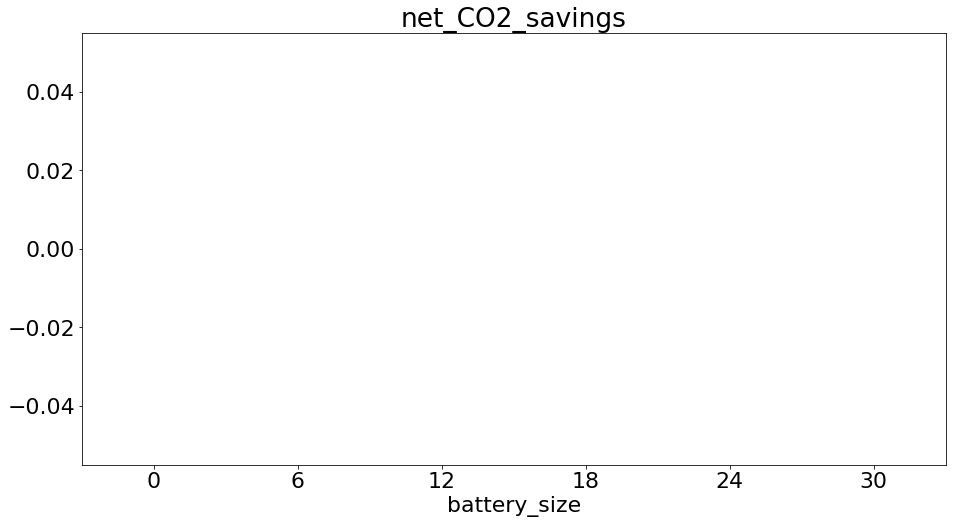

In [168]:
results_all.boxplot(by ='battery_size', column =['net_CO2_savings'], grid = False)
plt.suptitle('');

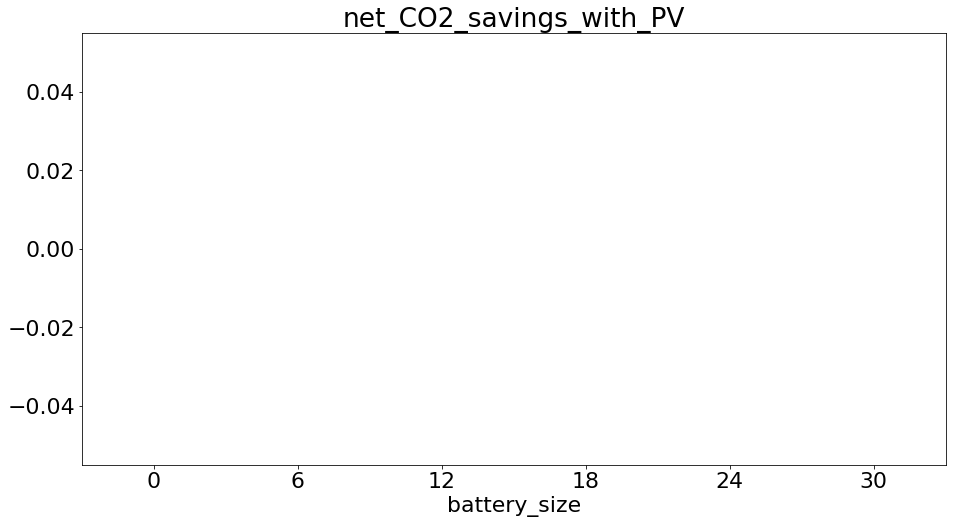

In [169]:
results_all.boxplot(by ='battery_size', column =['net_CO2_savings_with_PV'], grid = False)
plt.suptitle('');

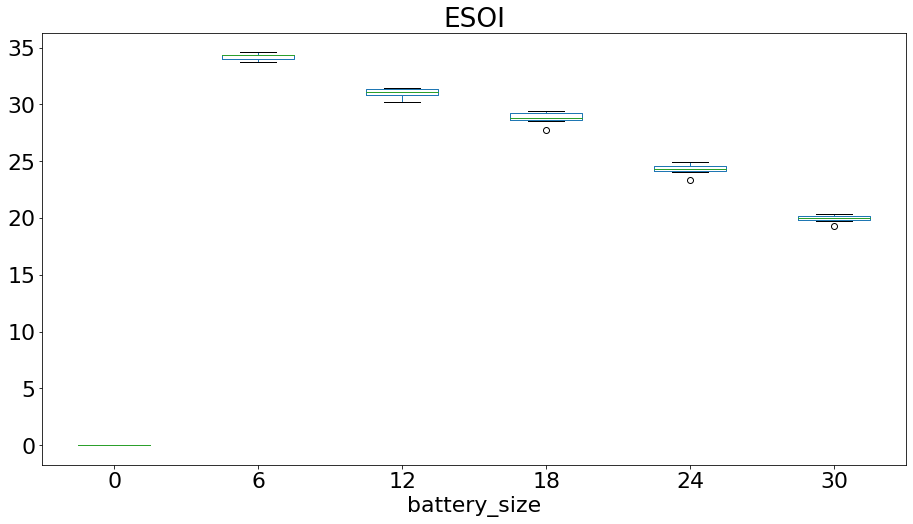

In [170]:
results_all.boxplot(by ='battery_size', column =['ESOI'], grid = False)
plt.suptitle('');

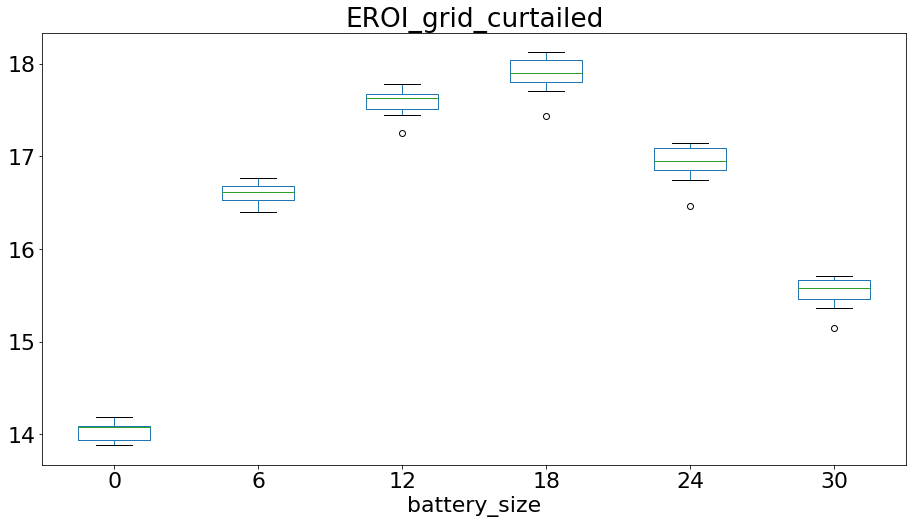

In [171]:
results_all.boxplot(by ='battery_size', column =['EROI_grid_curtailed'], grid = False)
plt.suptitle('');

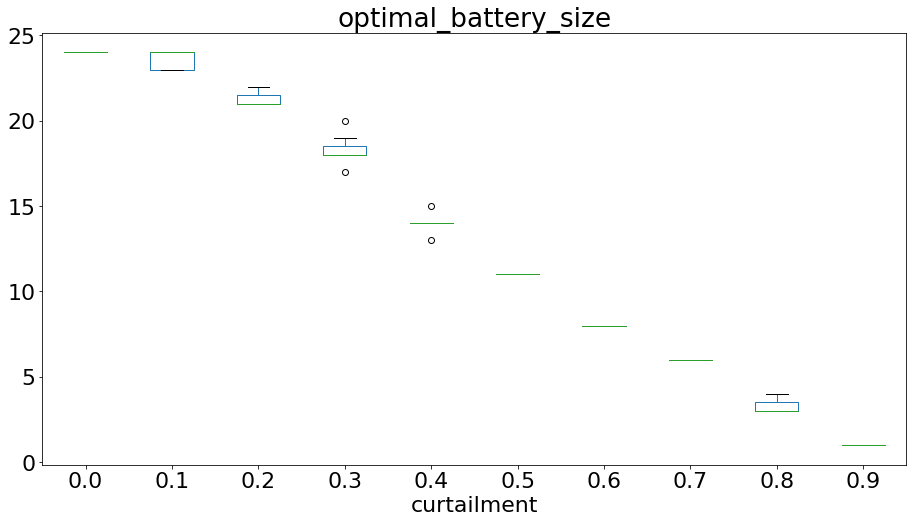

In [172]:
results_optimization_all.boxplot(by ='curtailment', column =['optimal_battery_size'], grid = False)
plt.suptitle('');

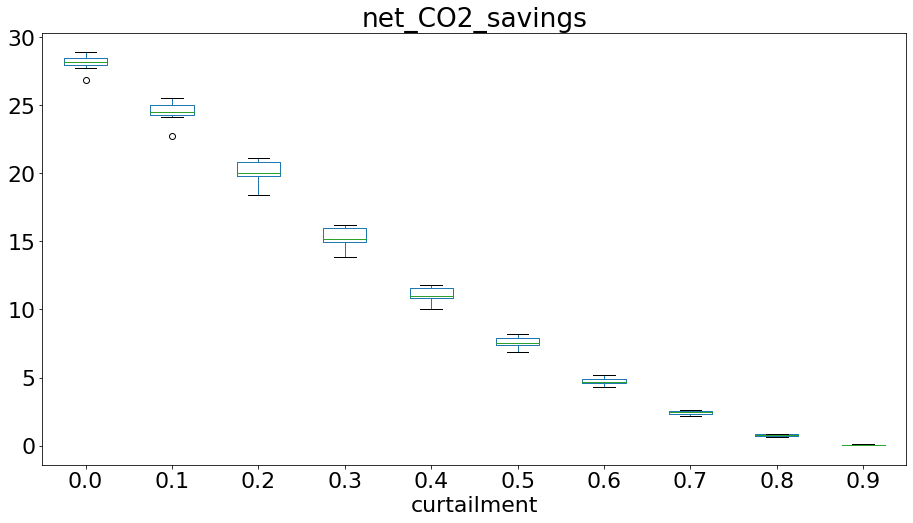

In [173]:
results_optimization_all.boxplot(by ='curtailment', column =['net_CO2_savings'], grid = False)
plt.suptitle('');